# European Option (Call/Put) Pricing & Greeks

We import the important libraries

In [1]:
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

We import from Yahoo the dataset for Apple Stock

In [2]:
stock = 'AAPL'
endDate = datetime.today()
startDate = endDate - timedelta(days = 360)

stock_data = yf.download(stock, startDate, endDate,auto_adjust=True, progress=False)
print(stock_data)   

Price            Close        High         Low        Open    Volume
Ticker            AAPL        AAPL        AAPL        AAPL      AAPL
Date                                                                
2024-11-13  224.323654  225.848241  221.972002  223.217580  48566200
2024-11-14  227.412704  228.060399  224.204094  224.224027  44923900
2024-11-15  224.204086  226.117293  223.476673  225.599128  47923700
2024-11-18  227.213394  228.927311  224.373470  224.453189  44633700
2024-11-19  227.472488  229.345843  225.858224  226.177084  36211800
...                ...         ...         ...         ...       ...
2025-11-03  269.049988  270.850006  266.250000  270.420013  50194600
2025-11-04  270.040009  271.489990  267.619995  268.329987  49274800
2025-11-05  270.140015  271.700012  266.929993  268.609985  43683100
2025-11-06  269.769989  273.399994  267.890015  267.890015  51157400
2025-11-07  268.470001  272.290009  266.769989  269.799988  48203600

[247 rows x 5 columns]


Let's get the annualized volatility for Apple Stock in the last year

In [3]:
daily_return = stock_data['Close'].pct_change(1)
daily_volatility = daily_return.std()
annualized_volatility = float(daily_volatility * np.sqrt(252))
print(f"Daily Apple volatility: {daily_volatility}")

Daily Apple volatility: Ticker
AAPL    0.02067
dtype: float64


C:\Users\maxim\AppData\Local\Temp\ipykernel_10792\892986513.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  annualized_volatility = float(daily_volatility * np.sqrt(252))


### Data

In [4]:
stock_price = float(stock_data['Close'].iloc[-1])
strike_price = stock_price  #at the money

risk_free_rate = 0.04
maturity = 1.0

print(f"The stock price of Apple is {stock_price}")

The stock price of Apple is 268.4700012207031


C:\Users\maxim\AppData\Local\Temp\ipykernel_10792\1277620544.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  stock_price = float(stock_data['Close'].iloc[-1])


### European Option Payoff

In [5]:
def european_option_payoff_final(S0, r, K, vol, T, flag, n_simulations, premium, short_long):
    
    z = np.random.standard_normal(n_simulations)
    S_t = S0 * np.exp((r - (0.5 * vol**2)) * T + vol * np.sqrt(T) * z)

    payoff = 0.0 

    if short_long == 'Long':
        if flag == 'Call':
            payoff = np.maximum(S_t - K, 0) - premium
        elif flag == 'Put':
            payoff = np.maximum(K - S_t, 0) - premium
        else:
            print("Erreur : Type d'option (Call/Put) non reconnu.")
            return 0.0

    elif short_long == 'Short':
        if flag == 'Call':
            payoff = premium - np.maximum(S_t - K, 0)
        elif flag == 'Put':
            payoff = premium - np.maximum(K - S_t, 0)
        else:
            print("Erreur : Type d'option (Call/Put) non reconnu.")
            return 0.0

    else:
        print("Erreur : Position (long/short) non reconnue.")
        return 0.0
    
    return np.exp(-r * T) * (np.sum(payoff) / n_simulations)

n_simulations = 100000
premium = 5
flags = ['Call', 'Put']
positions = ['Long','Short']
for f in flags:
    for p in positions:
        expected_payoff = european_option_payoff_final(stock_price, risk_free_rate, strike_price, annualized_volatility, maturity, f, n_simulations, premium, p)
        print(f"Le payoff espéré d'un {p} {f}: {expected_payoff:.4f}")

Le payoff espéré d'un Long Call: 34.8850
Le payoff espéré d'un Short Call: -35.0208
Le payoff espéré d'un Long Put: 24.6646
Le payoff espéré d'un Short Put: -24.4826


### Visualizations

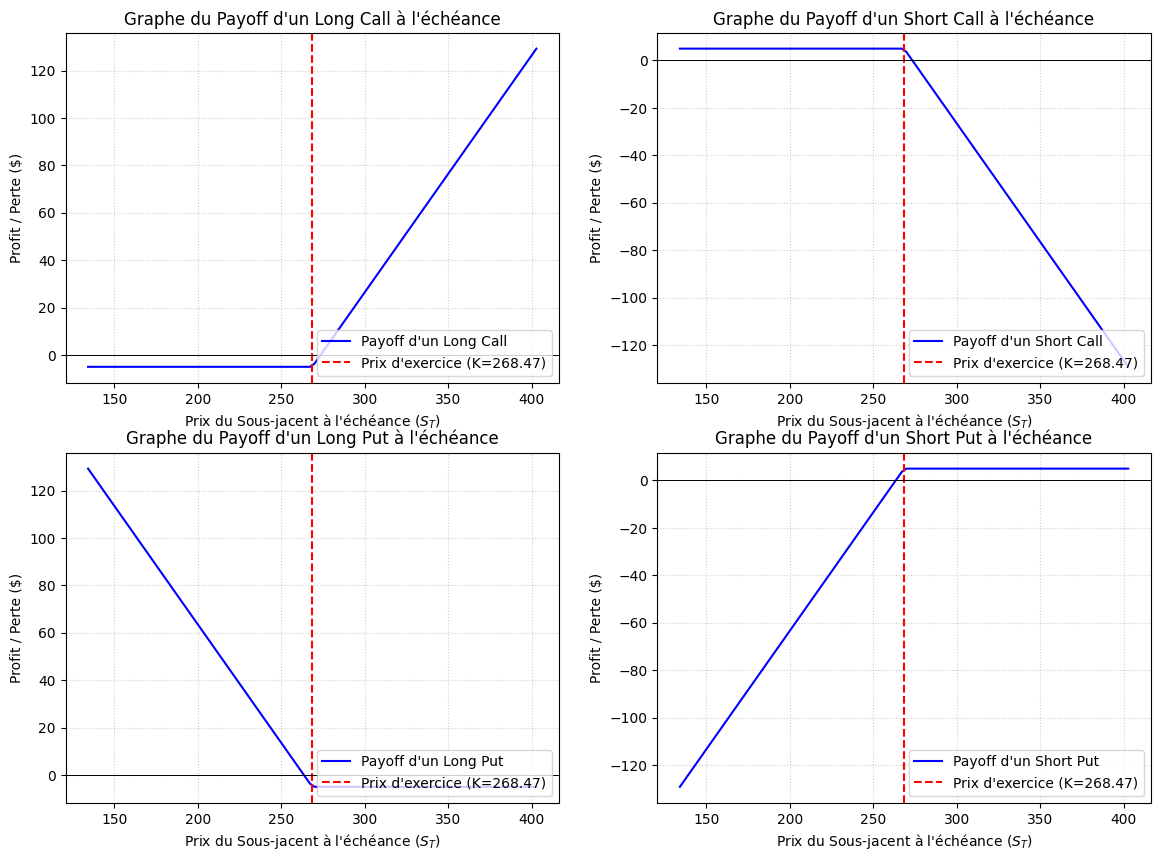

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
S_range = np.linspace(strike_price * 0.5, strike_price * 1.5, 100)

# --- 1. Initialisation de la variable de courbe (Solution à NameError) 
for i,f in enumerate(flags):
    for j,p in enumerate(positions):
        ax = axes[i,j]
        if p == 'Long':
            if f == 'Call':
                payoff_curve = np.maximum(S_range - strike_price, 0) - premium
            elif f == 'Put':
                payoff_curve = np.maximum(strike_price - S_range, 0) - premium
            else:
                error_message = "Erreur : Type d'option (Call/Put) non reconnu."

        elif p == 'Short':
            if f == 'Call':
                payoff_curve = premium - np.maximum(S_range - strike_price, 0)
            elif f == 'Put':
                payoff_curve = premium - np.maximum(strike_price - S_range, 0)
            else:
                error_message = "Erreur : Type d'option (Call/Put) non reconnu."

        else:
            error_message = "Erreur : Position (long/short) non reconnue."

# --- 2. Vérification avant de tracer ---
        ax.plot(S_range, payoff_curve, label=f"Payoff d'un {p} {f}", color='blue')
        ax.axvline(strike_price, color='red', linestyle='--', label=f"Prix d'exercice (K={strike_price:.2f})")
        ax.axhline(0, color='black', linestyle='-', linewidth=0.7)
        ax.set_title(f"Graphe du Payoff d'un {p} {f} à l'échéance")
        ax.set_xlabel("Prix du Sous-jacent à l'échéance ($S_T$)")
        ax.set_ylabel("Profit / Perte ($)")
        ax.grid(True, linestyle=':', alpha=0.6)
        ax.legend(loc='lower right')

### Greeks

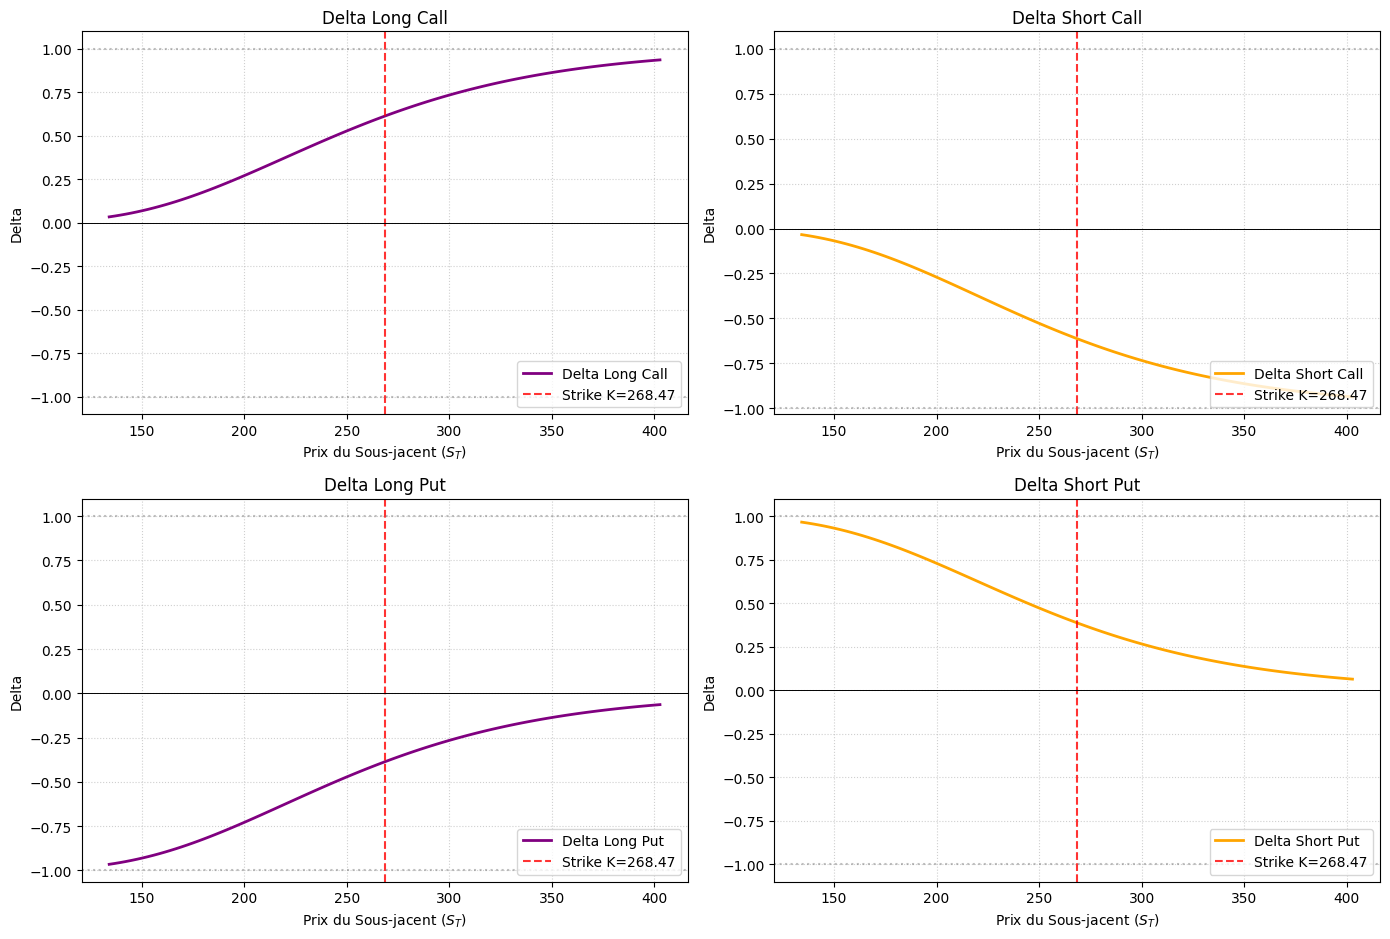

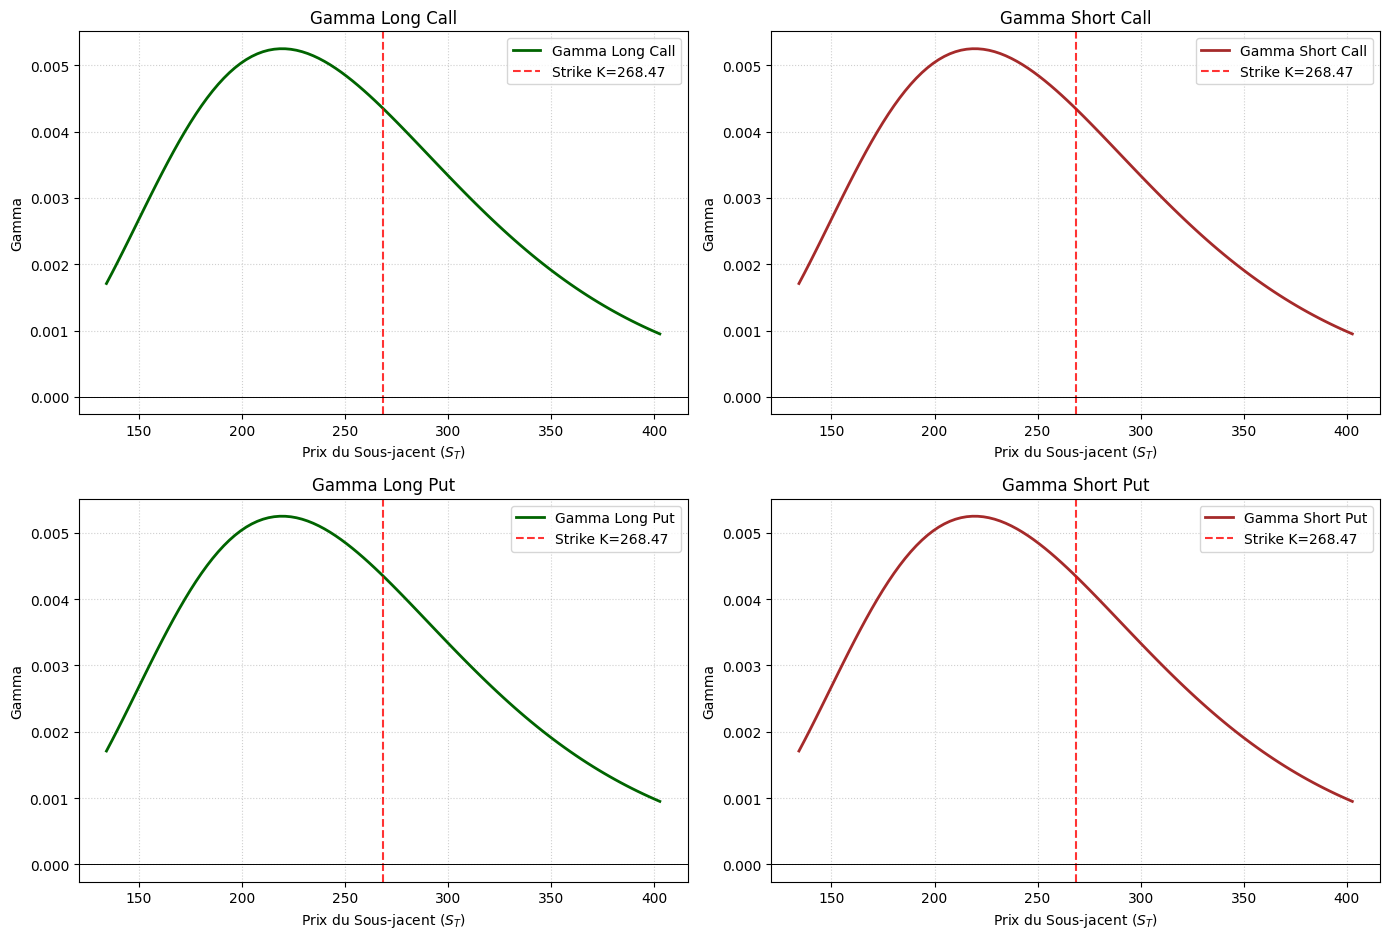

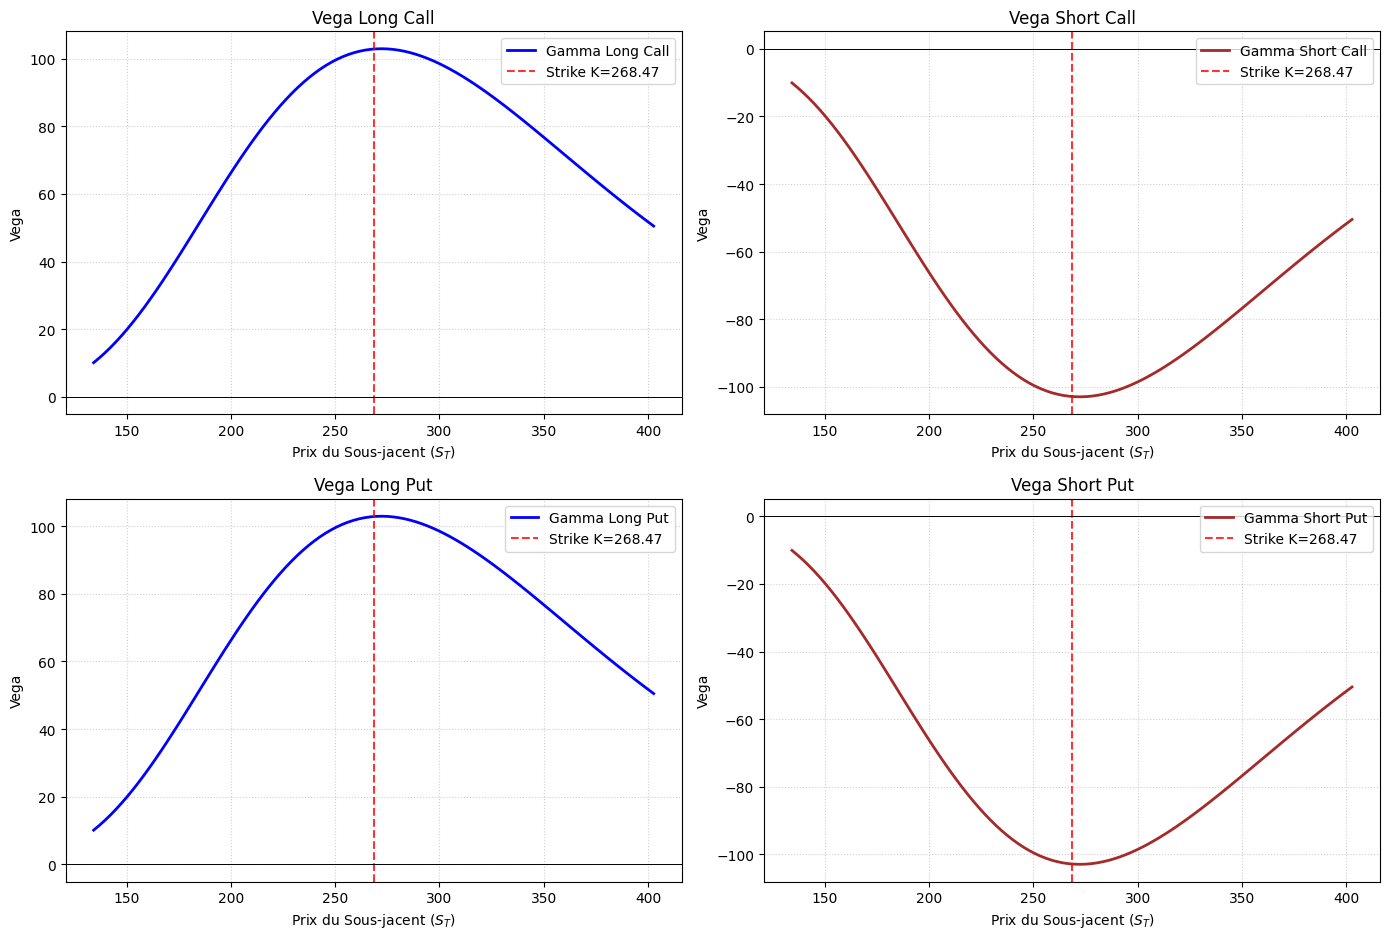

In [7]:
import scipy.stats as si
def black_scholes_greeks(S,K,r,T, vol, flag):
    d1 = (np.log(S/K)+(r+0.5*(vol**2))*T)/(vol*np.sqrt(T))
    d2 = d1 - vol*np.sqrt(T)

    N_d1 = si.norm.cdf(d1, 0.0, 1.0)
    N_d2 = si.norm.cdf(d2, 0.0, 1.0)
    N_d1_prime = si.norm.pdf(d1, 0.0,1.0)

    if(flag == 'call' or flag == 'Call'):
        delta = N_d1
    elif(flag == 'put' or flag == 'Put'):
        delta = N_d1 -1
    else:
        print("Please say if the option is a call or put")
        return 0.0,0.0

    gamma = N_d1_prime /(S*vol*np.sqrt(T))
    vega = N_d1_prime * np.sqrt(T) * S
    return delta, gamma, vega


#VISUALISATION

fig_delta, axes_delta = plt.subplots(2, 2, figsize=(14, 10))
fig_gamma, axes_gamma = plt.subplots(2, 2, figsize=(14, 10))
fig_vega, axes_vega = plt.subplots(2,2, figsize=  (14,10))
# --- 1. Initialisation de la variable de courbe (Solution à NameError) 
for i,f in enumerate(flags):
    for j,p in enumerate(positions):
        ax_d = axes_delta[i,j]
        ax_g = axes_gamma[i,j]
        ax_v = axes_vega[i,j]
        deltas_plot = []
        gammas_plot = []
        vegas_plot = []

        for S in S_range:
            _,gamma,_ = black_scholes_greeks(S, strike_price, risk_free_rate, maturity, annualized_volatility, f)
            gammas_plot.append(gamma)
            delta_long,_, _  = black_scholes_greeks(S, strike_price, risk_free_rate, maturity, annualized_volatility, f)
            delta_final = -delta_long if(p.lower()== 'short') else delta_long
            deltas_plot.append(delta_final)
            _,_,vega = black_scholes_greeks(S, strike_price, risk_free_rate, maturity, annualized_volatility, f)
            vega_final = -vega if(p.lower() == 'short') else vega
            vegas_plot.append(vega_final)

        
        color = 'purple' if p.lower() == 'long' else 'orange'
        ax_d.plot(S_range, deltas_plot, label=f"Delta {p} {f}", color=color, linewidth=2)
        
        ax_d.axvline(strike_price, color='red', linestyle='--', alpha=0.8, label=f"Strike K={strike_price:.2f}")
        ax_d.axhline(0.0, color='black', linestyle='-', linewidth=0.7)
        ax_d.axhline(1.0, color='gray', linestyle=':', alpha=0.5)
        ax_d.axhline(-1.0, color='gray', linestyle=':', alpha=0.5)
        
        ax_d.set_title(f"Delta {p} {f}")
        ax_d.set_xlabel("Prix du Sous-jacent ($S_T$)")
        ax_d.set_ylabel("Delta")
        ax_d.grid(True, linestyle=':', alpha=0.6)
        ax_d.legend(loc='lower right')


        color_g = 'darkgreen' if p.lower() == 'long' else 'brown'
        ax_g.plot(S_range, gammas_plot, label=f"Gamma {p} {f}", color=color_g, linewidth=2)
        
        # Mise en forme Gamma
        ax_g.axvline(strike_price, color='red', linestyle='--', alpha=0.8, label=f"Strike K={strike_price:.2f}")
        ax_g.axhline(0.0, color='black', linestyle='-', linewidth=0.7)
        
        ax_g.set_title(f"Gamma {p} {f}")
        ax_g.set_xlabel("Prix du Sous-jacent ($S_T$)")
        ax_g.set_ylabel("Gamma")
        ax_g.grid(True, linestyle=':', alpha=0.6)
        ax_g.legend(loc='upper right')


        color_v = 'blue' if p.lower() == 'long' else 'brown'
        ax_v.plot(S_range, vegas_plot, label=f"Gamma {p} {f}", color=color_v, linewidth=2)
        
        # Mise en forme Vega
        ax_v.axvline(strike_price, color='red', linestyle='--', alpha=0.8, label=f"Strike K={strike_price:.2f}")
        ax_v.axhline(0.0, color='black', linestyle='-', linewidth=0.7)
        
        ax_v.set_title(f"Vega {p} {f}")
        ax_v.set_xlabel("Prix du Sous-jacent ($S_T$)")
        ax_v.set_ylabel("Vega")
        ax_v.grid(True, linestyle=':', alpha=0.6)
        ax_v.legend(loc='upper right')
# Affichage des deux figures
plt.figure(fig_delta)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])

# AJOUT: Affichage de la figure Gamma
plt.figure(fig_gamma)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])

plt.figure(fig_vega)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])

plt.show() # Affiche la figure Gamma